In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

In [19]:
data = pd.read_excel('C:/Users/bbgog/paper/108_recruit_train.xlsx')
data = data[data['highest_school_level']!='F']
data = data.drop(['interview','second_interview','relabel'], axis=1)
data.head()

,id,sex,apply_age,marriage,highest_education,highest_graduation,loan,loan_status,military_status,aboriginal,height,weight,nationality,highest_school_level,english_level,hired_or_not,relabel_check
0,R224211691,F,24,0,B,Y,0,1,1,0,162,60,1,3,2.0,N,N
1,R223936966,F,28,0,B,Y,1,1,1,0,158,52,1,2,2.0,N,N
2,F228161684,F,24,0,B,Y,1,1,1,0,164,70,1,3,2.0,N,N
3,O200443001,F,21,0,B,Y,0,1,1,0,152,41,1,5,2.0,N,N
4,N225966272,F,22,0,B,I,0,1,1,0,155,45,1,6,3.0,N,N


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1188 entries, 0 to 1201
Data columns (total 17 columns):
id                      1188 non-null object
sex                     1188 non-null object
apply_age               1188 non-null int64
marriage                1188 non-null int64
highest_education       1188 non-null object
highest_graduation      1188 non-null object
loan                    1188 non-null int64
loan_status             1188 non-null int64
military_status         1188 non-null int64
aboriginal              1188 non-null int64
height                  1188 non-null int64
weight                  1188 non-null int64
nationality             1188 non-null int64
highest_school_level    1188 non-null object
english_level           1188 non-null float64
hired_or_not            1188 non-null object
relabel_check           1188 non-null object
dtypes: float64(1), int64(9), object(7)
memory usage: 167.1+ KB


In [5]:
print("應徵總人數", len(data))
print("男性應徵人數", len(data[data['sex']=='M']))
print("男性錄取人數", len(data[(data['sex']=='M') & (data['hired_or_not']=='Y')]))
print("男性錄取率", len(data[(data['sex']=='M') & (data['hired_or_not']=='Y')])/len(data[data['sex']=='M']))
print("女性應徵人數", len(data[data['sex']=='F']))
print("女性錄取人數", len(data[(data['sex']=='F') & (data['hired_or_not']=='Y')]))
print("女性錄取率", len(data[(data['sex']=='F') & (data['hired_or_not']=='Y')])/len(data[data['sex']=='F']))
print("男性應徵人數占比",len(data[data['sex']=='M'])/len(data))
print("女性應徵人數占比",len(data[data['sex']=='F'])/len(data))

應徵總人數 1188
男性應徵人數 412
男性錄取人數 39
男性錄取率 0.09466019417475728
女性應徵人數 776
女性錄取人數 63
女性錄取率 0.08118556701030928
男性應徵人數占比 0.3468013468013468
女性應徵人數占比 0.6531986531986532


In [6]:
# 設定資料集男女比及應徵錄取比
n_pop = 1000000
p_male = 0.3468
p_job_male, p_job_female = 0.0946, 0.0812

gender = np.random.choice(['male', 'female'], size=n_pop, p=[p_male, 1 - p_male])
df = pd.DataFrame({'gender' : gender})
df.loc[df.gender == 'male', 'found_job'] = np.random.choice([1, 0], size=len(df.loc[df.gender == 'male']), p=[p_job_male, 1 - p_job_male])
df.loc[df.gender == 'female', 'found_job'] = np.random.choice([1, 0], size=len(df.loc[df.gender == 'female']), p=[p_job_female, 1 - p_job_female])
df['found_job'] = df['found_job'].astype(int)

In [7]:
# 檢視資料集
print("男性應徵人數", len(df[df['gender']=='male']))
print("男性錄取人數", len(df[(df['gender']=='male') & (df['found_job']==1)]))
print("男性錄取率", len(df[(df['gender']=='male') & (df['found_job']==1)])/len(df[df['gender']=='male']))
print("女性應徵人數", len(df[df['gender']=='female']))
print("女性錄取人數", len(df[(df['gender']=='female') & (df['found_job']==1)]))
print("女性錄取率", len(df[(df['gender']=='female') & (df['found_job']==1)])/len(df[df['gender']=='female']))
print("男性應徵人數占比",len(df[df['gender']=='male'])/len(df))
print("女性應徵人數占比",len(df[df['gender']=='female'])/len(df))

男性應徵人數 346352
男性錄取人數 32722
男性錄取率 0.0944761398808149
女性應徵人數 653648
女性錄取人數 53046
女性錄取率 0.08115377083690305
男性應徵人數占比 0.346352
女性應徵人數占比 0.653648


In [8]:
df.pivot_table(index='gender', columns='found_job', aggfunc='size')

found_job,0,1
gender,,
female,600602,53046
male,313630,32722


In [9]:
print("男性錄取年齡平均", data[(data['sex']=='M') & (data['hired_or_not']=='Y')].apply_age.mean())
print("男性錄取年齡標準差", data[(data['sex']=='M') & (data['hired_or_not']=='Y')].apply_age.std())
print("男性未錄取年齡平均", data[(data['sex']=='M') & (data['hired_or_not']=='N')].apply_age.mean())
print("男性未錄取年齡標準差", data[(data['sex']=='M') & (data['hired_or_not']=='N')].apply_age.std())
print("---------------------------------------------------------------------")
print("女性錄取年齡平均", data[(data['sex']=='F') & (data['hired_or_not']=='Y')].apply_age.mean())
print("女性錄取年齡標準差", data[(data['sex']=='F') & (data['hired_or_not']=='Y')].apply_age.std())
print("女性未錄取年齡平均", data[(data['sex']=='F') & (data['hired_or_not']=='N')].apply_age.mean())
print("女性未錄取年齡標準差", data[(data['sex']=='F') & (data['hired_or_not']=='N')].apply_age.std())

男性錄取年齡平均 26.53846153846154
男性錄取年齡標準差 3.3938501180048863
男性未錄取年齡平均 27.396782841823057
男性未錄取年齡標準差 4.783842693106973
---------------------------------------------------------------------
女性錄取年齡平均 25.26984126984127
女性錄取年齡標準差 2.806710560059008
女性未錄取年齡平均 26.517531556802243
女性未錄取年齡標準差 4.669111814273186


In [10]:
# 設定資料集年齡分布(待採樣)
mu_job_male, sigma_job_male = 26.5385, 3.3939
mu_no_job_male, sigma_no_job_male = 27.3968, 4.7838

mu_job_female, sigma_job_female = 25.2698, 2.8067
mu_no_job_female, sigma_no_job_female = 26.5175, 4.6691

df_male = df[df['gender']=='male']
df_female = df[df['gender']=='female']

df_male.loc[df_male.found_job == 1, 'age'] = np.floor(np.random.normal(mu_job_male, sigma_job_male, len(df_male.loc[df_male.found_job == 1])))
df_male.loc[df_male.found_job == 0, 'age'] = np.floor(np.random.normal(mu_no_job_male, sigma_no_job_male, len(df_male.loc[df_male.found_job == 0])))
df_female.loc[df_female.found_job == 1, 'age'] = np.floor(np.random.normal(mu_job_female, sigma_job_female, len(df_female.loc[df_female.found_job == 1])))
df_female.loc[df_female.found_job == 0, 'age'] = np.floor(np.random.normal(mu_no_job_female, sigma_no_job_female, len(df_female.loc[df_female.found_job == 0])))

df = df_male.append(df_female)
df['age'] = df['age'].astype(int)

C:\Users\bbgog\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\bbgog\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [11]:
print("男性錄取年齡平均", df[(df['gender']=='male') & (df['found_job']==1)].age.mean())
print("男性錄取年齡標準差", df[(df['gender']=='male') & (df['found_job']==1)].age.std())
print("男性未錄取年齡平均", df[(df['gender']=='male') & (df['found_job']==0)].age.mean())
print("男性未錄取年齡標準差", df[(df['gender']=='male') & (df['found_job']==0)].age.std())
print("---------------------------------------------------------------------")
print("女性錄取年齡平均", df[(df['gender']=='female') & (df['found_job']==1)].age.mean())
print("女性錄取年齡標準差", df[(df['gender']=='female') & (df['found_job']==1)].age.std())
print("女性未錄取年齡平均", df[(df['gender']=='female') & (df['found_job']==0)].age.mean())
print("女性未錄取年齡標準差", df[(df['gender']=='female') & (df['found_job']==0)].age.std())

男性錄取年齡平均 26.053236354746044
男性錄取年齡標準差 3.435715343040166
男性未錄取年齡平均 26.90708159295986
男性未錄取年齡標準差 4.784530874286535
---------------------------------------------------------------------
女性錄取年齡平均 24.771368246427627
女性錄取年齡標準差 2.8249162527578937
女性未錄取年齡平均 26.015647633541015
女性未錄取年齡標準差 4.683298879567002


In [12]:
df.groupby('found_job').mean().round(1)

,age
found_job,
0,26.3
1,25.3


In [13]:
# 設定資料集學歷分布(待採樣)
print("學士人數", len(data[data['highest_education']=='B']))
print("碩士人數", len(data[data['highest_education']=='M']))
print("博士人數", len(data[data['highest_education']=='D']))
print("---------------------------------------------------------------------")
print("學士錄取人數", len(data[(data['highest_education']=='B') & (data['hired_or_not']=='Y')]))
print("碩士錄取人數", len(data[(data['highest_education']=='M') & (data['hired_or_not']=='Y')]))
print("博士錄取人數", len(data[(data['highest_education']=='D') & (data['hired_or_not']=='Y')]))
print("總錄取人數", len(data[data['hired_or_not']=='Y']))
print("---------------------------------------------------------------------")
print("學士錄取率", len(data[(data['highest_education']=='B') & (data['hired_or_not']=='Y')])/len(data[data['hired_or_not']=='Y']))
print("碩士錄取率", len(data[(data['highest_education']=='M') & (data['hired_or_not']=='Y')])/len(data[data['hired_or_not']=='Y']))
print("博士錄取率", len(data[(data['highest_education']=='D') & (data['hired_or_not']=='Y')])/len(data[data['hired_or_not']=='Y']))
print("---------------------------------------------------------------------")
print("學士不錄取率", len(data[(data['highest_education']=='B') & (data['hired_or_not']=='N')])/len(data[data['hired_or_not']=='N']))
print("碩士不錄取率", len(data[(data['highest_education']=='M') & (data['hired_or_not']=='N')])/len(data[data['hired_or_not']=='N']))
print("博士不錄取率", len(data[(data['highest_education']=='D') & (data['hired_or_not']=='N')])/len(data[data['hired_or_not']=='N']))

學士人數 1024
碩士人數 162
博士人數 2
---------------------------------------------------------------------
學士錄取人數 87
碩士錄取人數 15
博士錄取人數 0
總錄取人數 102
---------------------------------------------------------------------
學士錄取率 0.8529411764705882
碩士錄取率 0.14705882352941177
博士錄取率 0.0
---------------------------------------------------------------------
學士不錄取率 0.8627992633517495
碩士不錄取率 0.13535911602209943
博士不錄取率 0.001841620626151013


In [14]:
educ_class_set = ['B', 'M', 'D']
educ_class_wt_job = [0.8529, 0.1471, 0]
educ_class_wt_no_job = [0.8628, 0.1354, 0.0018]

df.loc[df.found_job == 1, 'educ_class'] = np.random.choice(educ_class_set, size=len(df.loc[df.found_job == 1]), p=educ_class_wt_job)
df.loc[df.found_job == 0, 'educ_class'] = np.random.choice(educ_class_set, size=len(df.loc[df.found_job == 0]), p=educ_class_wt_no_job)

In [15]:
# 檢視資料集學歷分布
print("學士人數", len(df[df['educ_class']=='B']))
print("碩士人數", len(df[df['educ_class']=='M']))
print("博士人數", len(df[df['educ_class']=='D']))
print("---------------------------------------------------------------------")
print("學士錄取人數", len(df[(df['educ_class']=='B') & (df['found_job']==1)]))
print("碩士錄取人數", len(df[(df['educ_class']=='M') & (df['found_job']==1)]))
print("博士錄取人數", len(df[(df['educ_class']=='D') & (df['found_job']==1)]))
print("總錄取人數", len(df[df['found_job']==1]))
print("---------------------------------------------------------------------")
print("學士錄取率", len(df[(df['educ_class']=='B') & (df['found_job']==1)])/len(df[df['found_job']==1]))
print("碩士錄取率", len(df[(df['educ_class']=='M') & (df['found_job']==1)])/len(df[df['found_job']==1]))
print("博士錄取率", len(df[(df['educ_class']=='D') & (df['found_job']==1)])/len(df[df['found_job']==1]))
print("---------------------------------------------------------------------")
print("學士不錄取率", len(df[(df['educ_class']=='B') & (df['found_job']==0)])/len(df[df['found_job']==0]))
print("碩士不錄取率", len(df[(df['educ_class']=='M') & (df['found_job']==0)])/len(df[df['found_job']==0]))
print("博士不錄取率", len(df[(df['educ_class']=='D') & (df['found_job']==0)])/len(df[df['found_job']==0]))

學士人數 862185
碩士人數 136079
博士人數 1736
---------------------------------------------------------------------
學士錄取人數 73282
碩士錄取人數 12486
博士錄取人數 0
總錄取人數 85768
---------------------------------------------------------------------
學士錄取率 0.8544212293629325
碩士錄取率 0.14557877063706745
博士錄取率 0.0
---------------------------------------------------------------------
學士不錄取率 0.8629133524094541
碩士不錄取率 0.1351877860324294
博士不錄取率 0.0018988615581165393


In [16]:
# 設定婚姻狀況資料分布(待採樣)
print("女性應徵總人數", len(data[data['sex']=='F']))
print("女性已婚總人數", len(data[(data['sex']=='F')&(data['marriage']==1)]))
print("女性未婚總人數", len(data[(data['sex']=='F')&(data['marriage']==0)]))
print("已錄取女性已婚人數", len(data[(data['sex']=='F')&(data['marriage']==1)&(data['hired_or_not']=='Y')]))
print("女性錄取者已婚比例", len(data[(data['sex']=='F')&(data['marriage']==1)&(data['hired_or_not']=='Y')])/len(data[(data['sex']=='F')&(data['hired_or_not']=='Y')]))
print("未錄取女性已婚人數", len(data[(data['sex']=='F')&(data['marriage']==1)&(data['hired_or_not']=='N')]))
print("女性未錄取者已婚比例", len(data[(data['sex']=='F')&(data['marriage']==1)&(data['hired_or_not']=='N')])/len(data[(data['sex']=='F')&(data['hired_or_not']=='N')]))
print("---------------------------------------------------------------------")
print("男性應徵總人數", len(data[data['sex']=='M']))
print("男性已婚總人數", len(data[(data['sex']=='M')&(data['marriage']==1)]))
print("男性未婚總人數", len(data[(data['sex']=='M')&(data['marriage']==0)]))
print("已錄取男性已婚人數", len(data[(data['sex']=='M')&(data['marriage']==1)&(data['hired_or_not']=='Y')]))
print("男性錄取者已婚比例", len(data[(data['sex']=='M')&(data['marriage']==1)&(data['hired_or_not']=='Y')])/len(data[(data['sex']=='M')&(data['hired_or_not']=='Y')]))
print("未錄取男性已婚人數", len(data[(data['sex']=='M')&(data['marriage']==1)&(data['hired_or_not']=='N')]))
print("男性未錄取者已婚比例", len(data[(data['sex']=='M')&(data['marriage']==1)&(data['hired_or_not']=='N')])/len(data[(data['sex']=='M')&(data['hired_or_not']=='N')]))
print("---------------------------------------------------------------------")
print("已婚女性錄取率", len(data[(data['sex']=='F')&(data['marriage']==1)&(data['hired_or_not']=='Y')])/len(data[(data['sex']=='F')&(data['marriage']==1)]))
print("未婚女性錄取率", len(data[(data['sex']=='F')&(data['marriage']==0)&(data['hired_or_not']=='Y')])/len(data[(data['sex']=='F')&(data['marriage']==0)]))
print("已婚男性錄取率", len(data[(data['sex']=='M')&(data['marriage']==1)&(data['hired_or_not']=='Y')])/len(data[(data['sex']=='M')&(data['marriage']==1)]))
print("未婚男性錄取率", len(data[(data['sex']=='M')&(data['marriage']==0)&(data['hired_or_not']=='Y')])/len(data[(data['sex']=='M')&(data['marriage']==0)]))

女性應徵總人數 776
女性已婚總人數 95
女性未婚總人數 681
已錄取女性已婚人數 3
女性錄取者已婚比例 0.047619047619047616
未錄取女性已婚人數 92
女性未錄取者已婚比例 0.12903225806451613
---------------------------------------------------------------------
男性應徵總人數 412
男性已婚總人數 31
男性未婚總人數 381
已錄取男性已婚人數 5
男性錄取者已婚比例 0.1282051282051282
未錄取男性已婚人數 26
男性未錄取者已婚比例 0.06970509383378017
---------------------------------------------------------------------
已婚女性錄取率 0.031578947368421054
未婚女性錄取率 0.0881057268722467
已婚男性錄取率 0.16129032258064516
未婚男性錄取率 0.08923884514435695


In [17]:
# 設定男女婚姻狀況分布
# 男性錄取者已婚比例, 男性未錄取者已婚比例
p_job_male_marriage, p_no_job_male_marriage = 0.12820512, 0.06970509
# 女性錄取者已婚比例, 女性未錄取者已婚比例
p_job_female_marriage, p_no_job_female_marriage = 0.04761904, 0.12903225

df_male = df[df['gender']=='male']
df_female = df[df['gender']=='female']

df_male.loc[df_male.found_job == 1, 'marriage'] = np.random.choice([1, 0], size=len(df_male.loc[df_male.found_job == 1]), p=[p_job_male_marriage, 1 - p_job_male_marriage])
df_male.loc[df_male.found_job == 0, 'marriage'] = np.random.choice([1, 0], size=len(df_male.loc[df_male.found_job == 0]), p=[p_no_job_male_marriage, 1 - p_no_job_male_marriage])
df_female.loc[df_female.found_job == 1, 'marriage'] = np.random.choice([1, 0], size=len(df_female.loc[df_female.found_job == 1]), p=[p_job_female_marriage, 1 - p_job_female_marriage])
df_female.loc[df_female.found_job == 0, 'marriage'] = np.random.choice([1, 0], size=len(df_female.loc[df_female.found_job == 0]), p=[p_no_job_female_marriage, 1 - p_no_job_female_marriage])

df = df_male.append(df_female)

In [18]:
# 設定婚姻狀況資料分布
print("女性應徵總人數", len(df[df['gender']=='female']))
print("女性已婚總人數", len(df[(df['gender']=='female')&(df['marriage']==1)]))
print("女性未婚總人數", len(df[(df['gender']=='female')&(df['marriage']==0)]))
print("已錄取女性已婚人數", len(df[(df['gender']=='female')&(df['marriage']==1)&(df['found_job']==1)]))
print("女性錄取者已婚比例", len(df[(df['gender']=='female')&(df['marriage']==1)&(df['found_job']==1)])/len(df[(df['gender']=='female')&(df['found_job']==1)]))
print("未錄取女性已婚人數", len(df[(df['gender']=='female')&(df['marriage']==1)&(df['found_job']==0)]))
print("女性未錄取者已婚比例", len(df[(df['gender']=='female')&(df['marriage']==1)&(df['found_job']==0)])/len(df[(df['gender']=='female')&(df['found_job']==0)]))
print("---------------------------------------------------------------------")
print("男性應徵總人數", len(df[df['gender']=='male']))
print("男性已婚總人數", len(df[(df['gender']=='male')&(df['marriage']==1)]))
print("男性未婚總人數", len(df[(df['gender']=='male')&(df['marriage']==0)]))
print("已錄取男性已婚人數", len(df[(df['gender']=='male')&(df['marriage']==1)&(df['found_job']==1)]))
print("男性錄取者已婚比例", len(df[(df['gender']=='male')&(df['marriage']==1)&(df['found_job']==1)])/len(df[(df['gender']=='male')&(df['found_job']==1)]))
print("未錄取男性已婚人數", len(df[(df['gender']=='male')&(df['marriage']==1)&(df['found_job']==0)]))
print("男性未錄取者已婚比例", len(df[(df['gender']=='male')&(df['marriage']==1)&(df['found_job']==0)])/len(df[(df['gender']=='male')&(df['found_job']==0)]))
print("---------------------------------------------------------------------")
print("已婚女性錄取率", len(df[(df['gender']=='female')&(df['marriage']==1)&(df['found_job']==1)])/len(df[(df['gender']=='female')&(df['marriage']==1)]))
print("未婚女性錄取率", len(df[(df['gender']=='female')&(df['marriage']==0)&(df['found_job']==1)])/len(df[(df['gender']=='female')&(df['marriage']==0)]))
print("已婚男性錄取率", len(df[(df['gender']=='male')&(df['marriage']==1)&(df['found_job']==1)])/len(df[(df['gender']=='male')&(df['marriage']==1)]))
print("未婚男性錄取率", len(df[(df['gender']=='male')&(df['marriage']==0)&(df['found_job']==1)])/len(df[(df['gender']=='male')&(df['marriage']==0)]))

女性應徵總人數 653648
女性已婚總人數 80492
女性未婚總人數 573156
已錄取女性已婚人數 2497
女性錄取者已婚比例 0.04707235229800551
未錄取女性已婚人數 77995
女性未錄取者已婚比例 0.12986137242300225
---------------------------------------------------------------------
男性應徵總人數 346352
男性已婚總人數 26186
男性未婚總人數 320166
已錄取男性已婚人數 4217
男性錄取者已婚比例 0.12887354073711876
未錄取男性已婚人數 21969
男性未錄取者已婚比例 0.07004750821031151
---------------------------------------------------------------------
已婚女性錄取率 0.0310217164438702
未婚女性錄取率 0.08819413911744796
已婚男性錄取率 0.16104025051554266
未婚男性錄取率 0.08903193968129033


In [19]:
# 檢視資料集借貸與錄取與否關係
print("有借貸者人數", len(data[data['loan']==1]))
print("有借貸且信用正常且錄取者", len(data[(data['loan']==1)&(data['loan_status']==1)&(data['hired_or_not']=='Y')]))
print("有借貸但信用異常且錄取者", len(data[(data['loan']==1)&(data['loan_status']==0)&(data['hired_or_not']=='Y')]))
print("無借貸且錄取者", len(data[(data['loan']==0)&(data['hired_or_not']=='Y')]))
print("有借貸且異常者占有信貸者比例", len(data[(data['loan']==1)&(data['loan_status']==0)])/len(data[data['loan']==1]))
print("---------------------------------------------------------------------")
print("有信貸者錄取率", len(data[(data['loan']==1)&(data['hired_or_not']=='Y')])/len(data[data['loan']==1]))
print("無信貸者錄取率", len(data[(data['loan']==0)&(data['hired_or_not']=='Y')])/len(data[data['loan']==0]))
print("---------------------------------------------------------------------")
print("錄取者有信貸比例", len(data[(data['loan']==1)&(data['hired_or_not']=='Y')])/len(data[(data['hired_or_not']=='Y')]))
print("未錄取者有信貸比例", len(data[(data['loan']==1)&(data['hired_or_not']=='N')])/len(data[(data['hired_or_not']=='N')]))

有借貸者人數 276
有借貸且信用正常且錄取者 28
有借貸但信用異常且錄取者 0
無借貸且錄取者 74
有借貸且異常者占有信貸者比例 0.014492753623188406
---------------------------------------------------------------------
有信貸者錄取率 0.10144927536231885
無信貸者錄取率 0.08114035087719298
---------------------------------------------------------------------
錄取者有信貸比例 0.27450980392156865
未錄取者有信貸比例 0.2283609576427256


In [20]:
# 建立信貸者資料
p_job_loan, p_no_job_loan = 0.27450980, 0.22836095
df.loc[df.found_job == 1, 'loan'] = np.random.choice([1, 0], size=len(df.loc[df.found_job == 1]), p=[p_job_loan, 1 - p_job_loan])
df.loc[df.found_job == 0, 'loan'] = np.random.choice([1, 0], size=len(df.loc[df.found_job == 0]), p=[p_no_job_loan, 1 - p_no_job_loan])

In [21]:
# 檢視資料集借貸與錄取與否關係
print("有借貸者人數", len(df[df['loan']==1]))
print("無借貸且錄取者", len(df[(df['loan']==0)&(df['found_job']==1)]))
print("---------------------------------------------------------------------")
print("有信貸者錄取率", len(df[(df['loan']==1)&(df['found_job']==1)])/len(df[df['loan']==1]))
print("無信貸者錄取率", len(df[(df['loan']==0)&(df['found_job']==1)])/len(df[df['loan']==0]))
print("---------------------------------------------------------------------")
print("錄取者有信貸比例", len(df[(df['loan']==1)&(df['found_job']==1)])/len(df[(df['found_job']==1)]))
print("未錄取者有信貸比例", len(df[(df['loan']==1)&(df['found_job']==0)])/len(df[(df['found_job']==0)]))

有借貸者人數 232442
無借貸且錄取者 62294
---------------------------------------------------------------------
有信貸者錄取率 0.10098863372368161
無信貸者錄取率 0.08115868768223379
---------------------------------------------------------------------
錄取者有信貸比例 0.2736918197929298
未錄取者有信貸比例 0.22857217861549367


In [22]:
# 檢視資料集不良信貸者
print("有信貸人數", len(data[(data['loan']==1)]))
print("有信貸且信用正常人數", len(data[(data['loan']==1)&(data['loan_status']==1)]))
print("有信貸但信用不正常人數", len(data[(data['loan']==1)&(data['loan_status']==0)]))
print("---------------------------------------------------------------------")
print("有信貸且信用正常錄取人數", len(data[(data['loan']==1)&(data['loan_status']==1)&(data['hired_or_not']=='Y')]))
print("有信貸且信用正常但未錄取人數", len(data[(data['loan']==1)&(data['loan_status']==1)&(data['hired_or_not']=='N')]))
print("有信貸但信用不正常錄取人數", len(data[(data['loan']==1)&(data['loan_status']==0)&(data['hired_or_not']=='Y')]))
print("有信貸但信用不正常且未錄取人數", len(data[(data['loan']==1)&(data['loan_status']==0)&(data['hired_or_not']=='N')]))
print("---------------------------------------------------------------------")
print("未錄取者中信用正常者佔比", len(data[(data['loan']==1)&(data['loan_status']==1)&(data['hired_or_not']=='N')])/len(data[(data['loan']==1)&(data['hired_or_not']=='N')]))
print("未錄取者中信用不正常者佔比", len(data[(data['loan']==1)&(data['loan_status']==0)&(data['hired_or_not']=='N')])/len(data[(data['loan']==1)&(data['hired_or_not']=='N')]))

有信貸人數 276
有信貸且信用正常人數 272
有信貸但信用不正常人數 4
---------------------------------------------------------------------
有信貸且信用正常錄取人數 28
有信貸且信用正常但未錄取人數 244
有信貸但信用不正常錄取人數 0
有信貸但信用不正常且未錄取人數 4
---------------------------------------------------------------------
未錄取者中信用正常者佔比 0.9838709677419355
未錄取者中信用不正常者佔比 0.016129032258064516


In [24]:
# 設定信貸狀況分布
# 未錄取信用狀況良好者
p_no_job_loan_good = 0.98387096

df_loan = df[df['loan']==1]
df_no_loan = df[df['loan']==0]

df_loan.loc[df_loan.found_job == 1, 'loan_status'] = np.random.choice([1, 0], size=len(df_loan.loc[df_loan.found_job == 1]), p=[1, 0])
df_loan.loc[df_loan.found_job == 0, 'loan_status'] = np.random.choice([1, 0], size=len(df_loan.loc[df_loan.found_job == 0]), p=[p_no_job_loan_good, 1-p_no_job_loan_good])

df = df_loan.append(df_no_loan)

In [25]:
# 檢視資料集不良信貸者
print("有信貸人數", len(df[(df['loan']==1)]))
print("有信貸且信用正常人數", len(df[(df['loan']==1)&(df['loan_status']==1)]))
print("有信貸但信用不正常人數", len(df[(df['loan']==1)&(df['loan_status']==0)]))
print("---------------------------------------------------------------------")
print("有信貸且信用正常錄取人數", len(df[(df['loan']==1)&(df['loan_status']==1)&(df['found_job']==1)]))
print("有信貸且信用正常但未錄取人數", len(df[(df['loan']==1)&(df['loan_status']==1)&(df['found_job']==0)]))
print("有信貸但信用不正常錄取人數", len(df[(df['loan']==1)&(df['loan_status']==0)&(df['found_job']==1)]))
print("有信貸但信用不正常且未錄取人數", len(df[(df['loan']==1)&(df['loan_status']==0)&(df['found_job']==0)]))
print("---------------------------------------------------------------------")
print("未錄取者中信用正常者佔比", len(df[(df['loan']==1)&(df['loan_status']==1)&(df['found_job']==0)])/len(df[(df['loan']==1)&(df['found_job']==0)]))
print("未錄取者中信用不正常者佔比", len(df[(df['loan']==1)&(df['loan_status']==0)&(df['found_job']==0)])/len(df[(df['loan']==1)&(df['found_job']==0)]))

有信貸人數 232442
有信貸且信用正常人數 229086
有信貸但信用不正常人數 3356
---------------------------------------------------------------------
有信貸且信用正常錄取人數 23474
有信貸且信用正常但未錄取人數 205612
有信貸但信用不正常錄取人數 0
有信貸但信用不正常且未錄取人數 3356
---------------------------------------------------------------------
未錄取者中信用正常者佔比 0.9839401248037977
未錄取者中信用不正常者佔比 0.01605987519620229


In [26]:
# 檢視服役狀況
print("役畢總人數", len(data[(data['sex']=='M')&(data['military_status']==1)]))
print("待畢總人數", len(data[(data['sex']=='M')&(data['military_status']==0)]))
print("錄取者中役畢人數", len(data[(data['sex']=='M')&(data['military_status']==1)&(data['hired_or_not']=='Y')]))
print("錄取者中未畢人數", len(data[(data['sex']=='M')&(data['military_status']==0)&(data['hired_or_not']=='Y')]))
print("未錄取者中役畢人數", len(data[(data['sex']=='M')&(data['military_status']==1)&(data['hired_or_not']=='N')]))
print("未錄取者中未畢人數", len(data[(data['sex']=='M')&(data['military_status']==0)&(data['hired_or_not']=='N')]))
print("---------------------------------------------------------")
print("錄取者中役畢占比", len(data[(data['sex']=='M')&(data['military_status']==1)&(data['hired_or_not']=='Y')])/len(data[(data['sex']=='M')&(data['hired_or_not']=='Y')]))
print("錄取者中未畢占比", len(data[(data['sex']=='M')&(data['military_status']==0)&(data['hired_or_not']=='Y')])/len(data[(data['sex']=='M')&(data['hired_or_not']=='Y')]))
print("未錄取者中役畢占比", len(data[(data['sex']=='M')&(data['military_status']==1)&(data['hired_or_not']=='N')])/len(data[(data['sex']=='M')&(data['hired_or_not']=='N')]))
print("未錄取者中未畢占比", len(data[(data['sex']=='M')&(data['military_status']==0)&(data['hired_or_not']=='N')])/len(data[(data['sex']=='M')&(data['hired_or_not']=='N')]))

役畢總人數 399
待畢總人數 13
錄取者中役畢人數 38
錄取者中未畢人數 1
未錄取者中役畢人數 361
未錄取者中未畢人數 12
---------------------------------------------------------
錄取者中役畢占比 0.9743589743589743
錄取者中未畢占比 0.02564102564102564
未錄取者中役畢占比 0.967828418230563
未錄取者中未畢占比 0.032171581769437


In [27]:
# 設定資料集服役情況
p_job_miliarty_status, p_no_job_military_status = 0.97435897, 0.96782841

df_male = df[df['gender']=='male']
df_female = df[df['gender']=='female']

df_male.loc[df_male.found_job == 1, 'military_status'] = np.random.choice([1, 0], size=len(df_male.loc[df_male.found_job == 1]), p=[p_job_miliarty_status, 1-p_job_miliarty_status])
df_male.loc[df_male.found_job == 0, 'military_status'] = np.random.choice([1, 0], size=len(df_male.loc[df_male.found_job == 0]), p=[p_no_job_military_status, 1-p_no_job_military_status])
df_female.loc[:,'military_status'] = 1

df = df_male.append(df_female)

In [28]:
# 檢視服役狀況
print("役畢總人數", len(df[(df['gender']=='male')&(df['military_status']==1)]))
print("待畢總人數", len(df[(df['gender']=='male')&(df['military_status']==0)]))
print("錄取者中役畢人數", len(df[(df['gender']=='male')&(df['military_status']==1)&(df['found_job']==1)]))
print("錄取者中未畢人數", len(df[(df['gender']=='male')&(df['military_status']==0)&(df['found_job']==1)]))
print("未錄取者中役畢人數", len(df[(df['gender']=='male')&(df['military_status']==1)&(df['found_job']==0)]))
print("未錄取者中未畢人數", len(df[(df['gender']=='male')&(df['military_status']==0)&(df['found_job']==0)]))
print("---------------------------------------------------------")
print("錄取者中役畢占比", len(df[(df['gender']=='male')&(df['military_status']==1)&(df['found_job']==1)])/len(df[(df['gender']=='male')&(df['found_job']==1)]))
print("錄取者中未畢占比", len(df[(df['gender']=='male')&(df['military_status']==0)&(df['found_job']==1)])/len(df[(df['gender']=='male')&(df['found_job']==1)]))
print("未錄取者中役畢占比", len(df[(df['gender']=='male')&(df['military_status']==1)&(df['found_job']==0)])/len(df[(df['gender']=='male')&(df['found_job']==0)]))
print("未錄取者中未畢占比", len(df[(df['gender']=='male')&(df['military_status']==0)&(df['found_job']==0)])/len(df[(df['gender']=='male')&(df['found_job']==0)]))

役畢總人數 335348
待畢總人數 11004
錄取者中役畢人數 31863
錄取者中未畢人數 859
未錄取者中役畢人數 303485
未錄取者中未畢人數 10145
---------------------------------------------------------
錄取者中役畢占比 0.9737485483772386
錄取者中未畢占比 0.026251451622761445
未錄取者中役畢占比 0.9676529668717916
未錄取者中未畢占比 0.0323470331282084


In [29]:
print("原住民身分總人數", len(data[data['aboriginal']==1]))
print("錄取者屬原住民身分者", len(data[(data['aboriginal']==1)&(data['hired_or_not']=='Y')]))
print("未錄取者屬原住民身分者", len(data[(data['aboriginal']==1)&(data['hired_or_not']=='N')]))
print("---------------------------------------------------------")
print("錄取者屬原住民身分者占比", len(data[(data['aboriginal']==1)&(data['hired_or_not']=='Y')])/len(data[(data['hired_or_not']=='Y')]))
print("未錄取者屬原住民身分者占比", len(data[(data['aboriginal']==1)&(data['hired_or_not']=='N')])/len(data[(data['hired_or_not']=='N')]))

原住民身分總人數 10
錄取者屬原住民身分者 1
未錄取者屬原住民身分者 9
---------------------------------------------------------
錄取者屬原住民身分者占比 0.00980392156862745
未錄取者屬原住民身分者占比 0.008287292817679558


In [30]:
# 設定資料集原住民身分
p_job_aboriginal, p_no_job_aboriginal = 0.00980392, 0.00828729

df.loc[df.found_job == 1, 'aboriginal'] = np.random.choice([1, 0], size=len(df.loc[df.found_job == 1]), p=[p_job_aboriginal, 1-p_job_aboriginal])
df.loc[df.found_job == 0, 'aboriginal'] = np.random.choice([1, 0], size=len(df.loc[df.found_job == 0]), p=[p_no_job_aboriginal, 1-p_no_job_aboriginal])

In [31]:
print("原住民身分總人數", len(df[df['aboriginal']==1]))
print("錄取者屬原住民身分者", len(df[(df['aboriginal']==1)&(df['found_job']==1)]))
print("未錄取者屬原住民身分者", len(df[(df['aboriginal']==1)&(df['found_job']==0)]))
print("---------------------------------------------------------")
print("錄取者屬原住民身分者占比", len(df[(df['aboriginal']==1)&(df['found_job']==1)])/len(df[(df['found_job']==1)]))
print("未錄取者屬原住民身分者占比", len(df[(df['aboriginal']==1)&(df['found_job']==0)])/len(df[(df['found_job']==0)]))

原住民身分總人數 8274
錄取者屬原住民身分者 812
未錄取者屬原住民身分者 7462
---------------------------------------------------------
錄取者屬原住民身分者占比 0.009467400429064453
未錄取者屬原住民身分者占比 0.008162042019968674


In [32]:
# 檢視資料集 BMI 分布
data.loc[:,'bmi'] = (data['weight'] / (data['height']/100 * data['height']/100)).round(1)
print("錄取男性bmi平均", data[(data['sex']=='M')&(data['hired_or_not']=='Y')].bmi.mean())
print("錄取男性bmi標準差", data[(data['sex']=='M')&(data['hired_or_not']=='Y')].bmi.std())
print("未錄取男性bmi平均", data[(data['sex']=='M')&(data['hired_or_not']=='N')].bmi.mean())
print("未錄取男性bmi標準差", data[(data['sex']=='M')&(data['hired_or_not']=='N')].bmi.std())
print("---------------------------------------------------------")
print("錄取女性bmi平均", data[(data['sex']=='F')&(data['hired_or_not']=='Y')].bmi.mean())
print("錄取女性bmi標準差", data[(data['sex']=='F')&(data['hired_or_not']=='Y')].bmi.std())
print("未錄取女性bmi平均", data[(data['sex']=='F')&(data['hired_or_not']=='N')].bmi.mean())
print("未錄取女性bmi標準差", data[(data['sex']=='F')&(data['hired_or_not']=='N')].bmi.std())

錄取男性bmi平均 23.474358974358978
錄取男性bmi標準差 2.583624336054209
未錄取男性bmi平均 22.98739946380696
未錄取男性bmi標準差 3.2864133706349055
---------------------------------------------------------
錄取女性bmi平均 19.603174603174608
錄取女性bmi標準差 1.7807182543232611
未錄取女性bmi平均 20.42272089761572
未錄取女性bmi標準差 2.564294567958626


In [33]:
# 設定資料集BMI分布
mu_job_male_bmi, mu_job_female_bmi = 23.47435897, 19.60317460
sigma_job_male_bmi, sigma_job_female_bmi = 2.58362433, 1.78071825
mu_no_job_male_bmi, mu_no_job_female_bmi = 22.98739946, 20.42272089
sigma_no_job_male_bmi, sigma_no_job_female_bmi = 3.28641337, 2.56429456

df_male = df[df['gender']=='male']
df_female = df[df['gender']=='female']

df_male.loc[df_male.found_job == 1, 'bmi'] = np.floor(np.random.normal(mu_job_male_bmi, sigma_job_male_bmi, len(df_male.loc[df_male.found_job == 1])))
df_male.loc[df_male.found_job == 0, 'bmi'] = np.floor(np.random.normal(mu_no_job_male_bmi, sigma_no_job_male_bmi, len(df_male.loc[df_male.found_job == 0])))
df_female.loc[df_female.found_job == 1, 'bmi'] = np.floor(np.random.normal(mu_job_female_bmi, sigma_job_female_bmi, len(df_female.loc[df_female.found_job == 1])))
df_female.loc[df_female.found_job == 0, 'bmi'] = np.floor(np.random.normal(mu_no_job_female_bmi, sigma_no_job_female_bmi, len(df_female.loc[df_female.found_job == 0])))

df = df_male.append(df_female)
df.head()

,age,educ_class,found_job,gender,loan,loan_status,marriage,military_status,aboriginal,bmi
0,28,B,0,male,1.0,1.0,0.0,1.0,0.0,24.0
13,31,B,0,male,1.0,1.0,0.0,1.0,0.0,25.0
20,22,B,0,male,1.0,1.0,0.0,1.0,0.0,17.0
24,20,B,0,male,1.0,1.0,0.0,1.0,0.0,19.0
39,22,B,0,male,1.0,1.0,0.0,1.0,0.0,23.0


# 原始資料訓練

In [20]:
data['marriage'] = data['marriage'].replace(0,"N").replace(1,"Y")
data['hired_or_not'] = data['hired_or_not'].replace("Y",1).replace("N",0)
data.loc[:,'bmi'] = (data['weight'] / (data['height']/100 * data['height']/100)).round(1)
data = data.drop(['id','relabel_check','height','weight'], axis=1)

In [57]:
def get_disparity_index(di):
    return 1 - np.minimum(di, 1 / di)

def get_bal_acc(classified_metric):
    return 0.5 * (classified_metric.true_positive_rate() + classified_metric.true_negative_rate())

def train_lr_model(dataset):
    scale = StandardScaler().fit(dataset.features)
    model = LogisticRegression(random_state=0, solver='liblinear')
    x_train = scale.transform(dataset.features)
    y_train = dataset.labels.ravel()
    model.fit(x_train, y_train, sample_weight=dataset.instance_weights)
    y_train_pred = model.predict(x_train)
    return model, scale

def test_lr_model(y_data_pred_prob, dataset, thresh_arr):
    y_pred = (y_data_pred_prob[:,1] > thresh_arr).astype(np.double)
    dataset_pred = dataset.copy()
    dataset_pred.labels = y_pred
    classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_group, privileged_group)
    metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_group, privileged_group)
    return dataset_pred.labels, classified_metric, metric_pred

def get_y_pred_prob_lr(scale, model, dataset):
    x = scale.transform(dataset.features)
    y_pred_prob = model.predict_proba(x)
    return y_pred_prob

def get_best_bal_acc_cutoff(y_pred_prob, dataset):
    y_validate_pred_prob = y_pred_prob
    bal_acc_arr = []
    disp_imp_arr = []

    for thresh in tqdm(thresh_arr):
        y_validate_pred = (y_validate_pred_prob[:,1] > thresh).astype(np.double)
        dataset_pred = dataset.copy()
        dataset_pred.labels = y_validate_pred

        # Calculate accuracy for each threshold value
        classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_group, privileged_group)
        bal_acc = get_bal_acc(classified_metric)
        bal_acc_arr.append(bal_acc)

        # Calculate fairness for each threshold value
        metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_group, privileged_group)
        disp_imp_arr.append(metric_pred.disparate_impact())

    # Find threshold for best accuracy
    thresh_arr_best_ind = np.where(bal_acc_arr == np.max(bal_acc_arr))[0][0]
    thresh_arr_best = np.array(thresh_arr)[thresh_arr_best_ind]

    # Calculate accuracy and fairness at this threshold
    best_bal_acc = bal_acc_arr[thresh_arr_best_ind]
    disp_imp_at_best_bal_acc = disp_imp_arr[thresh_arr_best_ind]

    # Output metrics
    acc_metrics = pd.DataFrame({'thresh_arr_best_ind' : thresh_arr_best_ind, \
    'thresh_arr_best' : thresh_arr_best, \
    'best_bal_acc' : best_bal_acc, \
    'disp_imp_at_best_bal_acc' : disp_imp_at_best_bal_acc}, index=[0]).transpose()
    return acc_metrics, bal_acc_arr, disp_imp_arr, dataset_pred.labels


def plot_acc_vs_fairness(metric, metric_name, bal_acc_arr, thresh_arr_best_ind):
    fig, ax1 = plt.subplots(figsize=(10, 7))
    ax1.plot(thresh_arr, bal_acc_arr, color='b')
    ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14, labelcolor='b')
    ax2 = ax1.twinx()
    ax2.plot(thresh_arr, metric, color='r')
    ax2.set_ylabel(metric_name, color='r', fontsize=16, fontweight='bold')
    ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14, labelcolor='r')
    ax2.grid(True)

In [21]:
data.head()

,sex,apply_age,marriage,highest_education,highest_graduation,loan,loan_status,military_status,aboriginal,nationality,highest_school_level,english_level,hired_or_not,bmi
0,F,24,N,B,Y,0,1,1,0,1,3,2.0,0,22.9
1,F,28,N,B,Y,1,1,1,0,1,2,2.0,0,20.8
2,F,24,N,B,Y,1,1,1,0,1,3,2.0,0,26.0
3,F,21,N,B,Y,0,1,1,0,1,5,2.0,0,17.7
4,F,22,N,B,I,0,1,1,0,1,6,3.0,0,18.7


# 將男女資料分開來處理並訓練模型

In [25]:
# 女性做婚姻狀態檢查
df_female = data[data['sex']=='F']
df_female = df_female.drop('sex', axis=1)
df_female.head()

,apply_age,marriage,highest_education,highest_graduation,loan,loan_status,military_status,aboriginal,nationality,highest_school_level,english_level,hired_or_not,bmi
0,24,N,B,Y,0,1,1,0,1,3,2.0,0,22.9
1,28,N,B,Y,1,1,1,0,1,2,2.0,0,20.8
2,24,N,B,Y,1,1,1,0,1,3,2.0,0,26.0
3,21,N,B,Y,0,1,1,0,1,5,2.0,0,17.7
4,22,N,B,I,0,1,1,0,1,6,3.0,0,18.7


# Convert to AIF360 format

In [26]:
df_onehot = pd.concat([df_female[['hired_or_not', 'apply_age', 'loan', 'loan_status', 'military_status', 'aboriginal', 'nationality', 'highest_school_level', 'english_level', 'bmi']], 
                        pd.get_dummies(df_female[['highest_education', 'highest_graduation', 'marriage']])], axis=1)
df_onehot.head()

,hired_or_not,apply_age,loan,loan_status,military_status,aboriginal,nationality,highest_school_level,english_level,bmi,highest_education_B,highest_education_D,highest_education_M,highest_graduation_I,highest_graduation_Y,marriage_N,marriage_Y
0,0,24,0,1,1,0,1,3,2.0,22.9,1,0,0,0,1,1,0
1,0,28,1,1,1,0,1,2,2.0,20.8,1,0,0,0,1,1,0
2,0,24,1,1,1,0,1,3,2.0,26.0,1,0,0,0,1,1,0
3,0,21,0,1,1,0,1,5,2.0,17.7,1,0,0,0,1,1,0
4,0,22,0,1,1,0,1,6,3.0,18.7,1,0,0,1,0,1,0


In [29]:
df_aif = BinaryLabelDataset(df=df_onehot.drop('marriage_N', axis=1), label_names=['hired_or_not'], protected_attribute_names=['marriage_Y'])

In [30]:
privileged_group = [{'marriage_Y': 0}]
unprivileged_group = [{'marriage_Y': 1}]

In [31]:
df_orig_trn, df_orig_val, df_orig_tst = df_aif.split([0.5, 0.8], shuffle=True)
print([x.features.shape for x in [df_orig_trn, df_orig_val, df_orig_tst]])

[(388, 15), (232, 15), (156, 15)]


# Compute fairness metric on original dataset

In [36]:
metric_orig_trn = BinaryLabelDatasetMetric(df_orig_trn, unprivileged_group, privileged_group)
print('1-min(DI, 1/DI):', get_disparity_index(metric_orig_trn.disparate_impact()).round(3))

1-min(DI, 1/DI): 0.723


# Train model on original dataset

In [39]:
lr_orig, lr_scale_orig = train_lr_model(df_orig_trn)

In [40]:
thresh_arr = np.linspace(0.01, 0.5, 100)

In [43]:
y_validate_pred_prob_orig = get_y_pred_prob_lr(scale=lr_scale_orig, model=lr_orig, dataset=df_orig_val)

In [53]:
acc_metrics_orig, bal_acc_arr_orig, disp_imp_arr_orig, dataset_pred_labels_orig = \
get_best_bal_acc_cutoff(y_pred_prob=y_validate_pred_prob_orig, dataset=df_orig_val)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\bbgog\Anaconda3\lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)
100%|██████████| 100/100 [00:00<00:00, 1699.43it/s]


In [54]:
print('Threshold corresponding to best balanced accuracy:', acc_metrics_orig.loc['thresh_arr_best', 0].round(3))
print('Best balanced accuracy:', acc_metrics_orig.loc['best_bal_acc', 0].round(3))
print('1-min(DI, 1/DI):', get_disparity_index(acc_metrics_orig.loc['disp_imp_at_best_bal_acc', 0]).round(3))

Threshold corresponding to best balanced accuracy: 0.04
Best balanced accuracy: 0.593
1-min(DI, 1/DI): 0.915


C:\Users\bbgog\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


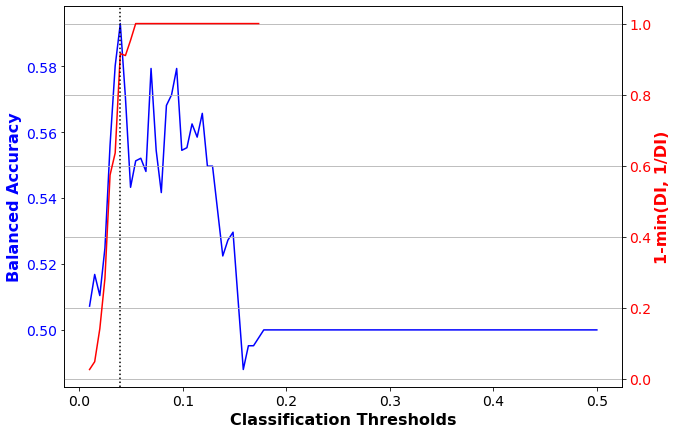

In [55]:
plot_acc_vs_fairness(get_disparity_index(np.array(disp_imp_arr_orig)), \
  '1-min(DI, 1/DI)', bal_acc_arr_orig, \
  acc_metrics_orig.loc['thresh_arr_best_ind', 0].astype(int))

# Test model on original dataset

In [58]:
y_test_pred_prob_orig = get_y_pred_prob_lr(scale=lr_scale_orig, model=lr_orig, dataset=df_orig_tst)

dataset_pred_labels_orig, classified_metric_orig, metric_pred_orig = test_lr_model(\
  y_data_pred_prob=y_test_pred_prob_orig, dataset=df_orig_tst,\
  thresh_arr=acc_metrics_orig.loc['thresh_arr_best', 0])

In [59]:
print('Threshold corresponding to best balanced accuracy:', acc_metrics_orig.loc['thresh_arr_best', 0].round(3))
print('Best balanced accuracy:', get_bal_acc(classified_metric_orig).round(3))
print('1-min(DI, 1/DI):', get_disparity_index(metric_pred_orig.disparate_impact()).round(3))

Threshold corresponding to best balanced accuracy: 0.04
Best balanced accuracy: 0.608
1-min(DI, 1/DI): 0.747


# Bias mitigation

In [60]:
RW = Reweighing(unprivileged_group, privileged_group)
df_transf_trn = RW.fit_transform(df_orig_trn)

In [61]:
metric_transf_trn = BinaryLabelDatasetMetric(df_transf_trn, unprivileged_group, privileged_group)
print('1-min(DI, 1/DI):', get_disparity_index(metric_transf_trn.disparate_impact()).round(3))

1-min(DI, 1/DI): 0.0


# Train model on transformed dataset# 

In [62]:
lr_transf, lr_scale_transf = train_lr_model(df_transf_trn)

In [63]:
y_validate_pred_prob_transf = get_y_pred_prob_lr(scale=lr_scale_transf, model=lr_transf, dataset=df_orig_val)

In [65]:
acc_metrics_transf, bal_acc_arr_transf, disp_imp_arr_transf, dataset_pred_labels_transf = \
get_best_bal_acc_cutoff(y_pred_prob=y_validate_pred_prob_transf, dataset=df_orig_val)

100%|██████████| 100/100 [00:00<00:00, 1822.27it/s]


In [66]:
print('Threshold corresponding to best balanced accuracy:', acc_metrics_transf.loc['thresh_arr_best', 0].round(3))
print('Best balanced accuracy:', acc_metrics_transf.loc['best_bal_acc', 0].round(3))
print('1-min(DI, 1/DI):', get_disparity_index(acc_metrics_transf.loc['disp_imp_at_best_bal_acc', 0]).round(3))

Threshold corresponding to best balanced accuracy: 0.114
Best balanced accuracy: 0.594
1-min(DI, 1/DI): 0.143


C:\Users\bbgog\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


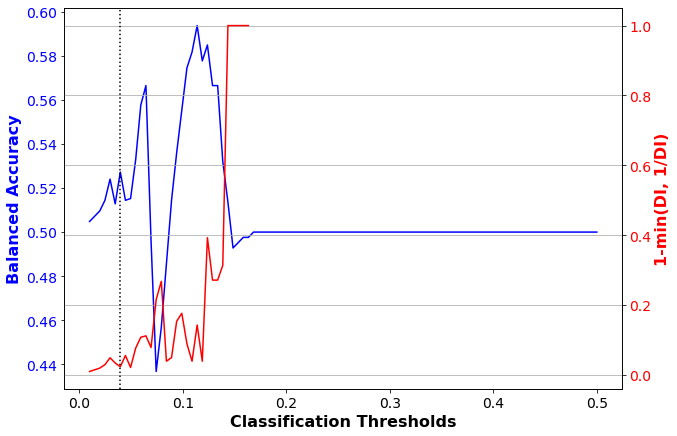

In [67]:
plot_acc_vs_fairness(get_disparity_index(np.array(disp_imp_arr_transf)), \
  '1-min(DI, 1/DI)', bal_acc_arr_transf, \
  acc_metrics_orig.loc['thresh_arr_best_ind', 0].astype(int))

# Test model on transformed dataset

In [68]:
y_test_pred_prob_transf = get_y_pred_prob_lr(scale=lr_scale_transf, model=lr_transf, dataset=df_orig_tst)

dataset_pred_labels_transf, classified_metric_transf, metric_pred_transf = test_lr_model(\
  y_data_pred_prob=y_test_pred_prob_transf, dataset=df_orig_tst,\
  thresh_arr=acc_metrics_transf.loc['thresh_arr_best', 0])

In [69]:
print('Threshold corresponding to best balanced accuracy:', acc_metrics_transf.loc['thresh_arr_best', 0].round(3))
print('Best balanced accuracy:', get_bal_acc(classified_metric_transf).round(3))
print('1-min(DI, 1/DI):', get_disparity_index(metric_pred_transf.disparate_impact()).round(3))

Threshold corresponding to best balanced accuracy: 0.114
Best balanced accuracy: 0.448
1-min(DI, 1/DI): 0.641
